In [1]:
import os
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name_or_path = "./Llama3.2-3B/" 
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    # torch_dtype=torch.float16, 
    device_map="auto", 
)

def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob)
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

tokenizer.pad_token = tokenizer.eos_token 




Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
def apply_lora_to_model(model, lora_config):
    for name, module in model.named_modules():
        if name in lora_config.target_modules: 

            r = lora_config.r
            alpha = lora_config.alpha
            dropout = lora_config.dropout

            module.lora_weight = torch.nn.Parameter(torch.zeros((r, module.weight.shape[1])))
            module.lora_bias = torch.nn.Parameter(torch.zeros((module.weight.shape[0], r)))

            torch.nn.init.xavier_uniform_(module.lora_weight)
            module.lora_alpha = alpha
            module.lora_dropout = torch.nn.Dropout(dropout)

            def forward_with_lora(x, module=module):
                base_output = torch.matmul(x, module.weight.t())
                lora_output = torch.matmul(x, module.lora_weight.t()) * (module.lora_alpha / lora_config.r)
                return base_output + module.lora_dropout(lora_output)

            module.forward = forward_with_lora

In [3]:



checkpoint_path = "./.Llama3.2-3B-Fine-Tuning/Llama3B_joke_generator_lora_1.pt" 
# model.load_state_dict(torch.load(models_path))

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'], strict=False)

device='cuda'

In [4]:

def predict(input_text, length_of_joke,number_of_jokes):
    joke_num = 0
    model.eval()
    with torch.no_grad():
        for joke_idx in range(number_of_jokes):
        
            joke_finished = False

            cur_ids = torch.tensor(tokenizer.encode('JOKE:' + input_text)).unsqueeze(0).to(device)

            for i in range(length_of_joke):
                outputs = model(cur_ids, labels=cur_ids)
                loss, logits = outputs[:2]
                softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
                if i < 3:
                    n = 20
                else:
                    n = 3
                next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
                cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

                if next_token_id in tokenizer.encode('<|endoftext|>'):
                    joke_finished = True
                    break

            

                
            joke_num = joke_num + 1
                
            output_list = list(cur_ids.squeeze().to('cpu').numpy())
            output_text = tokenizer.decode(output_list)

            print(output_text+'\n')



In [5]:
input_text = "If life gives you melons"

predict(input_text, 64, 5)

<|begin_of_text|>JOKE:If life gives you melons, eat them.
If life gives you melons, eat them.
A man was walking down the street with his girlfriend. He was holding a melon and she was carrying a bag of groceries.
A passer-by asked the man what he had in the bag.
The man replied that it was melon.
The man

<|begin_of_text|>JOKE:If life gives you melons, don't be a melon, be a watermelon.
JOKE:If life gives you melons, don't be a melon, be a watermelon.<|end_of_text|><|begin_of_text|>

<|begin_of_text|>JOKE:If life gives you melons…
If life gives you melons, make lemonade.
If life gives you melons and lemons, make lemonade and then kick the person who gave you the lemons.
If life gives you melons and lemons, make lemonade and then kick the person who gave you the lemons and then sue

<|begin_of_text|>JOKE:If life gives you melons, get a job!
I was thinking about the other day, how I have never seen a melon that wasn’t green. I mean, I’ve never seen one that wasn’t green. It’s like the on

In [6]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
class Jokesdataset(Dataset):
    '''
    This class builds the custom dataset for Dataloader
    '''
    def __init__(self,data,tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.eos_tok = "<|endoftext|>"
        #Adding JOKE: at the start and EOS TOKEN at end
        self.data['Joke'] = self.data['Joke'].apply(lambda x: "JOKE:" + str(x) + self.eos_tok)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        joke = self.data.iloc[idx,1]
    
        inputs = self.tokenizer.encode_plus(
            joke,
            None,
            add_special_tokens = True,
            max_length = 64,
            pad_to_max_length = True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {'ids':torch.tensor(ids,dtype=torch.long),
            'mask': torch.tensor(mask,dtype=torch.long),
            'target':torch.tensor(ids,dtype=torch.long)}
        
    def random_split_joke(self, idx):
        joke = joke = self.data.iloc[idx,1]
        words = joke.split()
        split_ratio = np.random.uniform(0.3, 0.7)
        split_index = int(len(words) * split_ratio)
        return " ".join(words[:split_index]), joke

jokes = pd.read_csv("/home/scxzc2/project/jokGen/reddit-cleanjokes.csv")

dataset = Jokesdataset(jokes,tokenizer)
dataloader = DataLoader(dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=4)

['<|begin_of_text|>', 'JO', 'KE', ':', 'Two', 'Ġartists', 'Ġhad', 'Ġan', 'Ġart', 'Ġcontest', '...', 'ĠIt', 'Ġended', 'Ġin', 'Ġa', 'Ġdraw', '<', '|', 'endo', 'ft', 'ext', '|', '>']


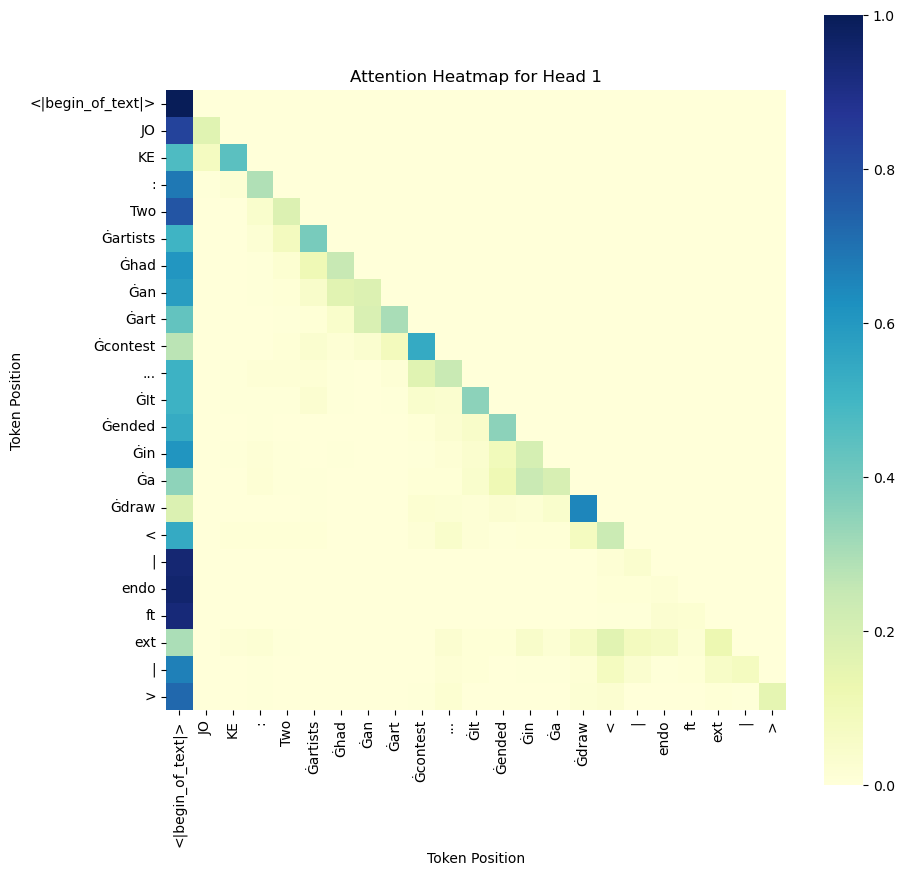

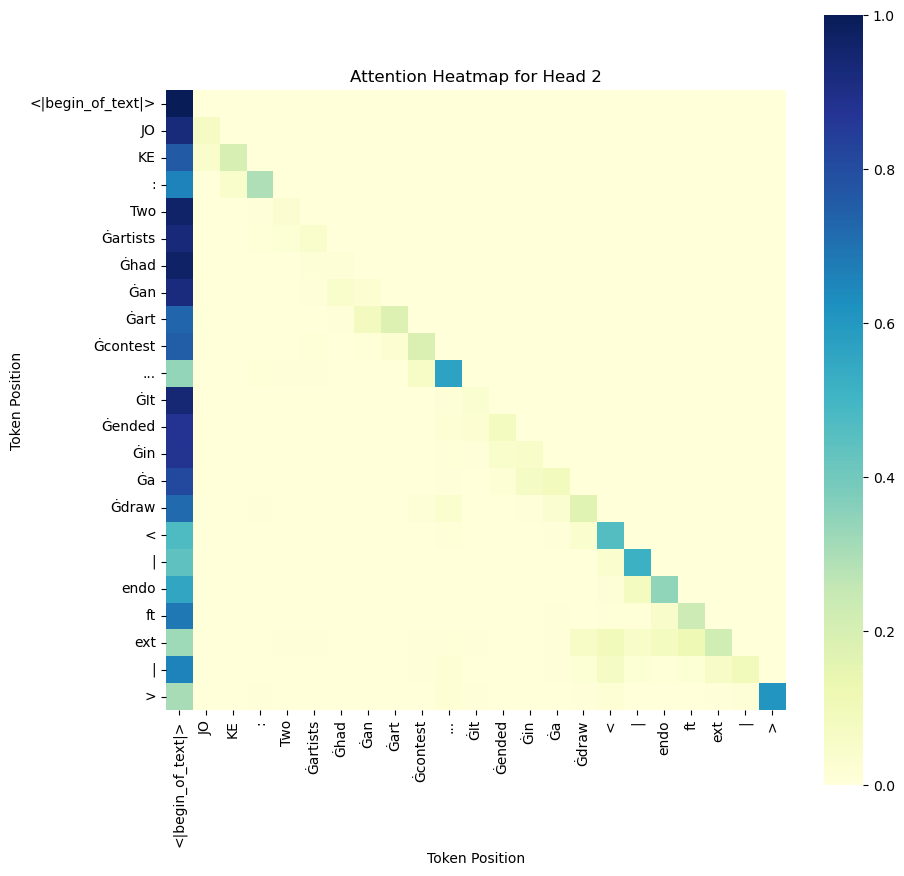

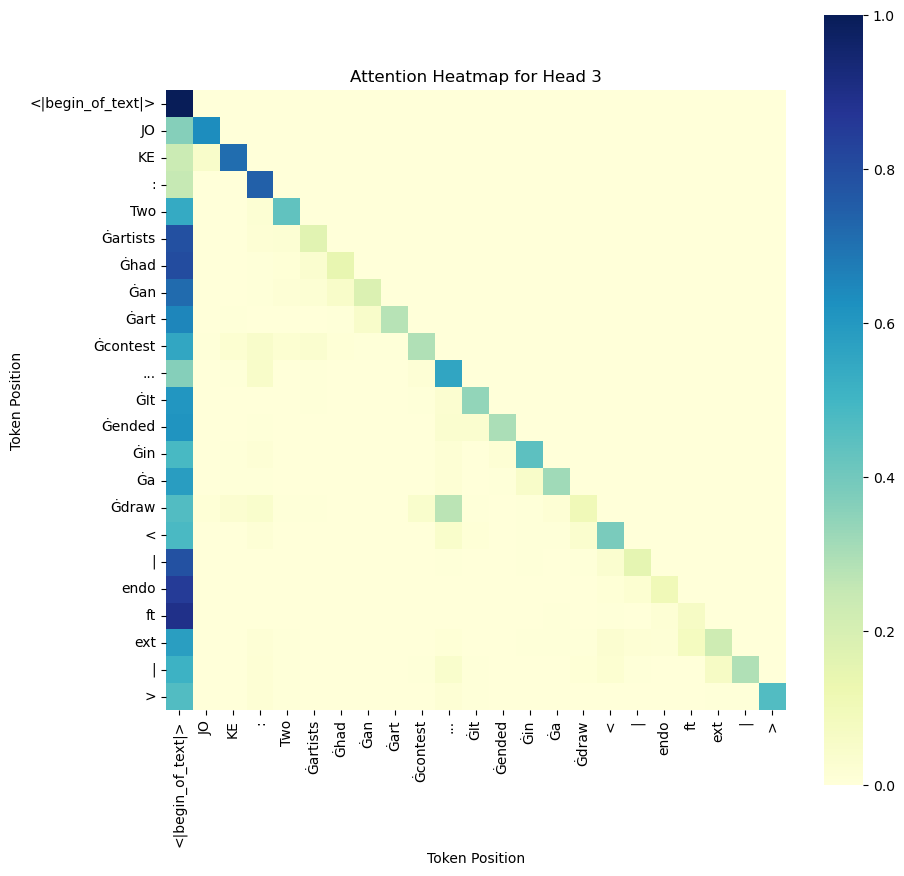

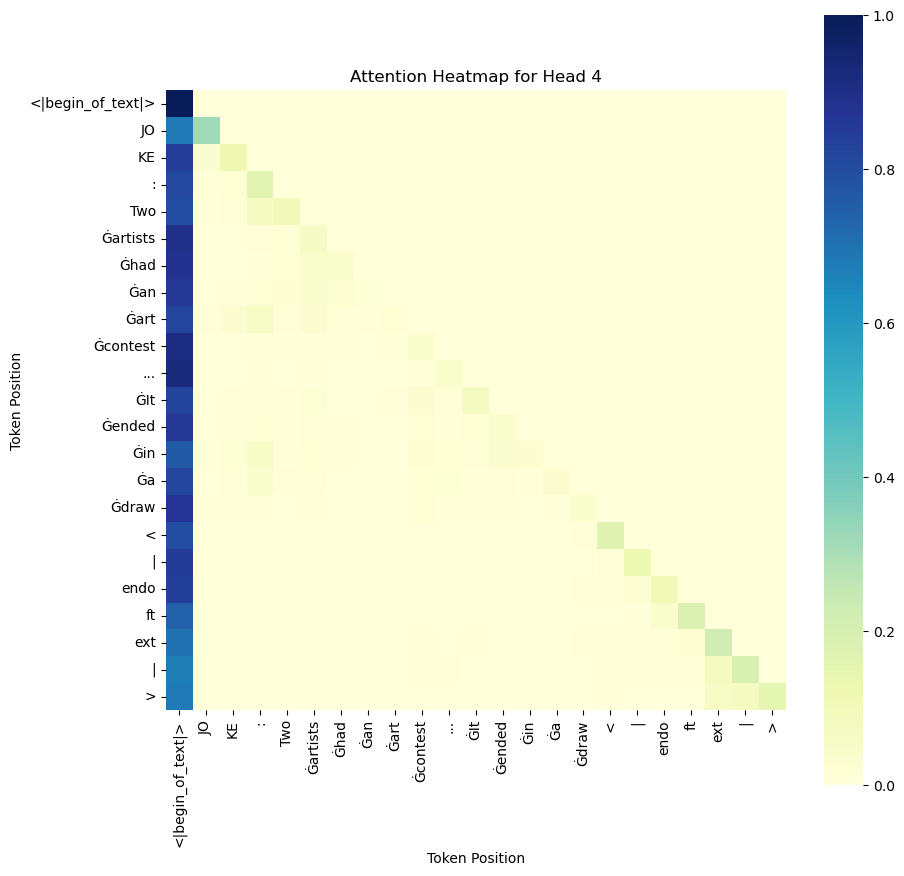

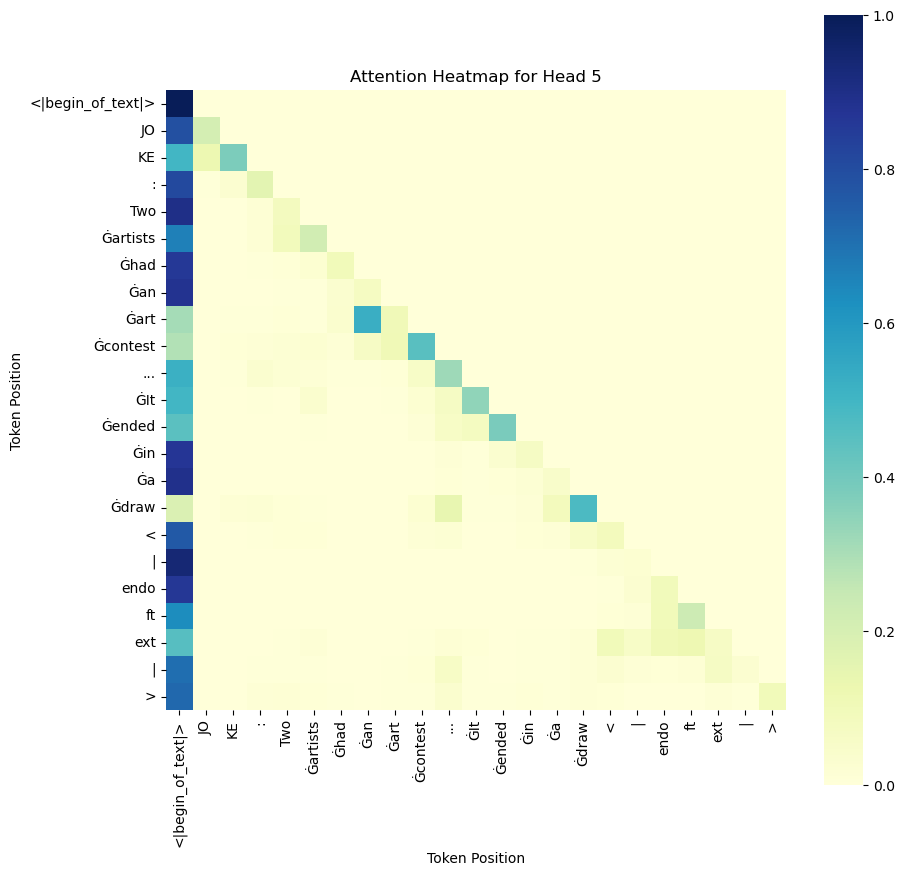

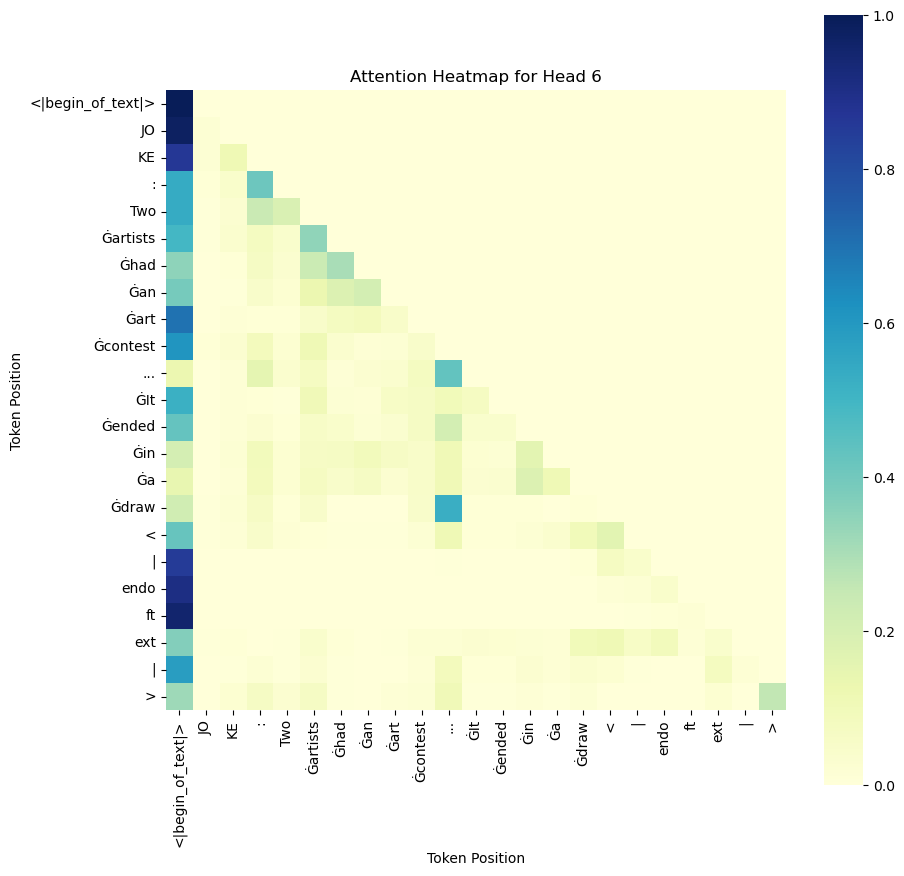

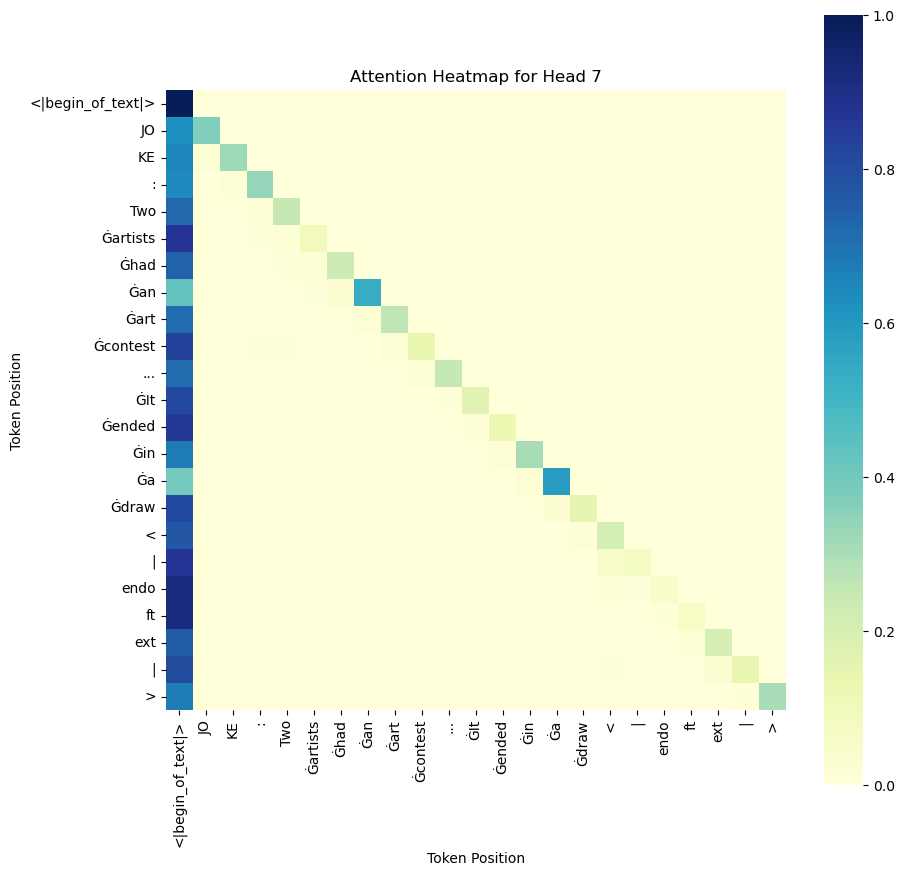

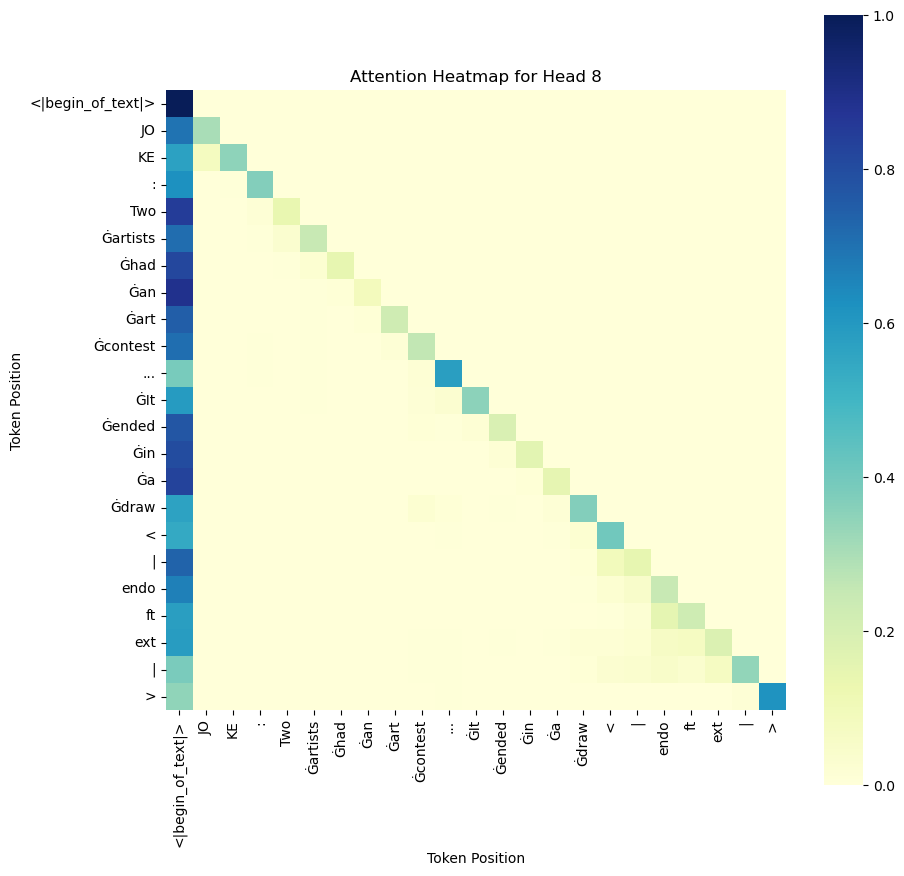

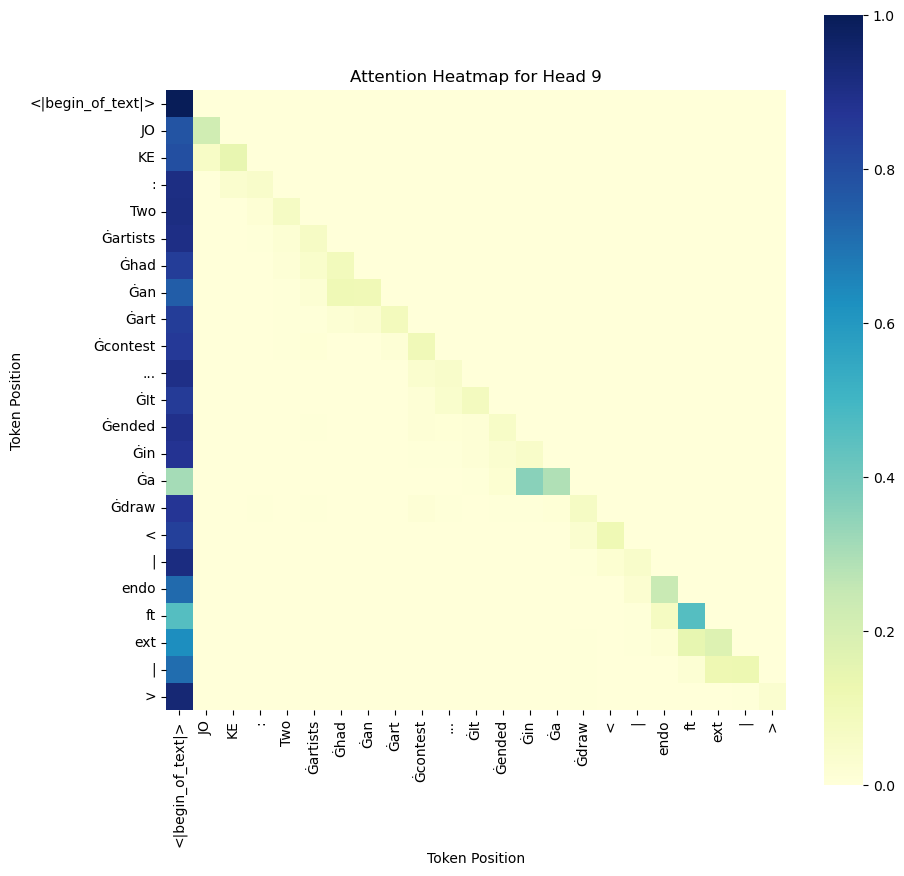

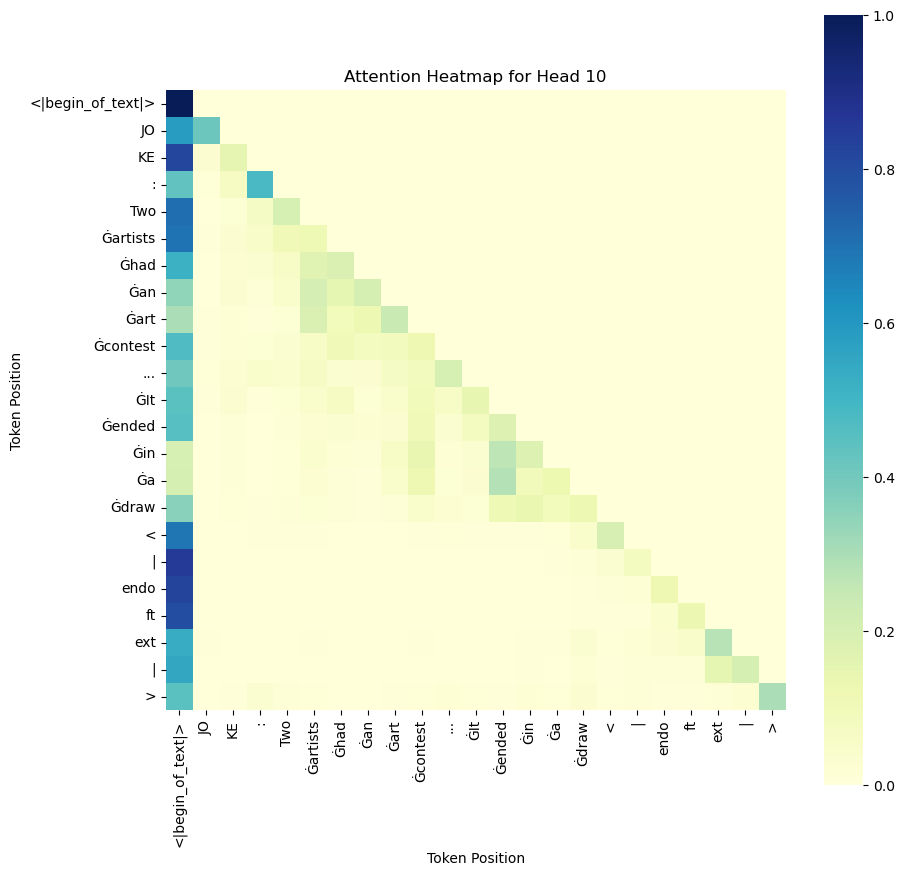

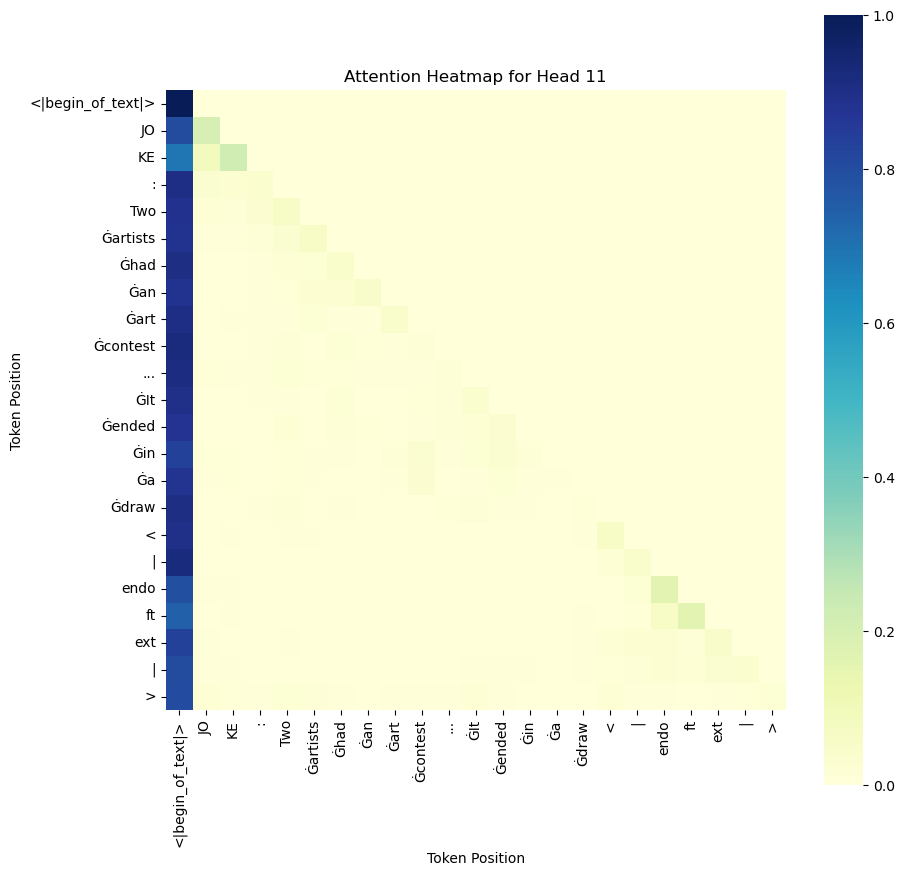

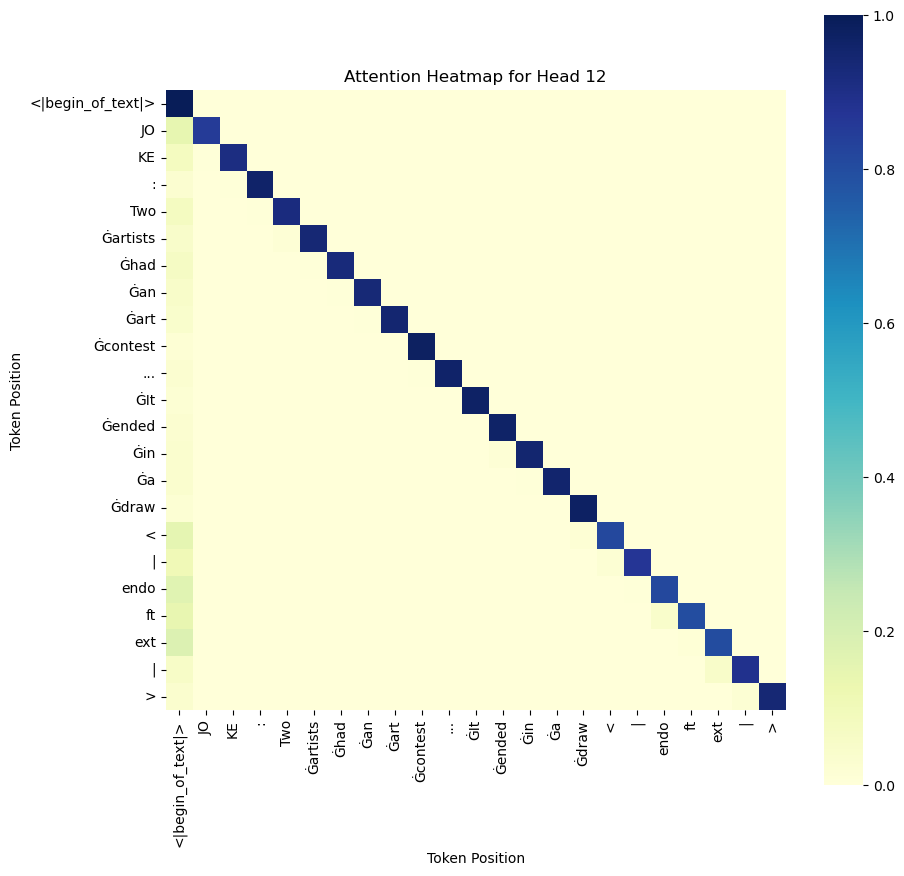

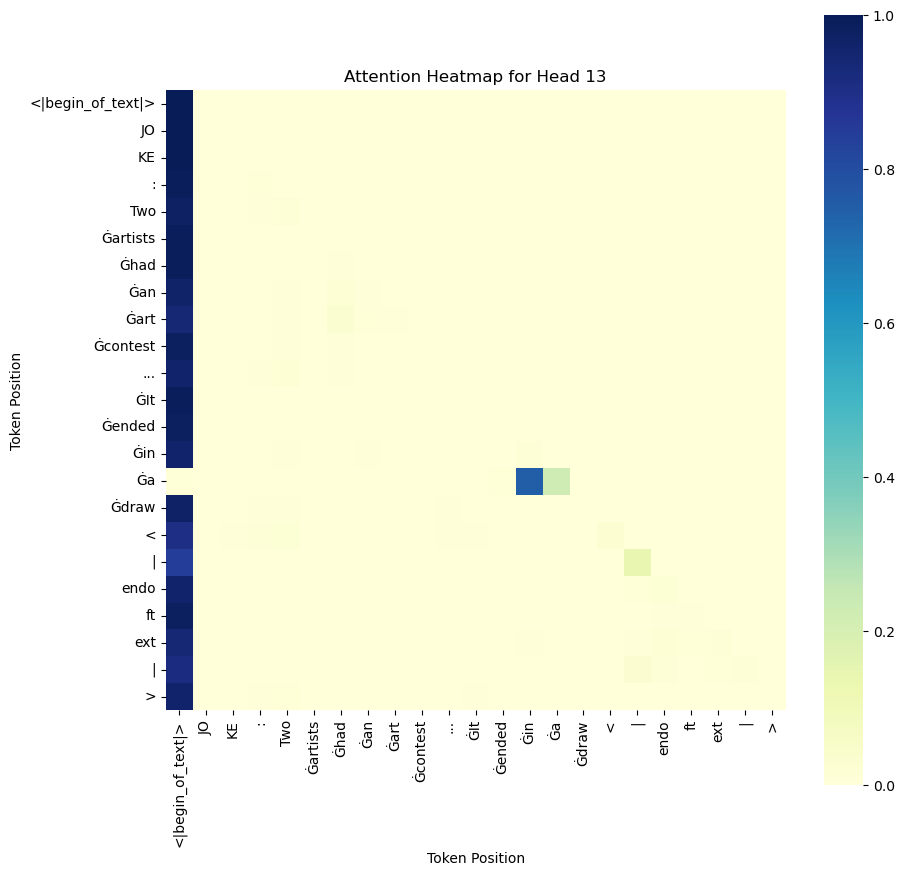

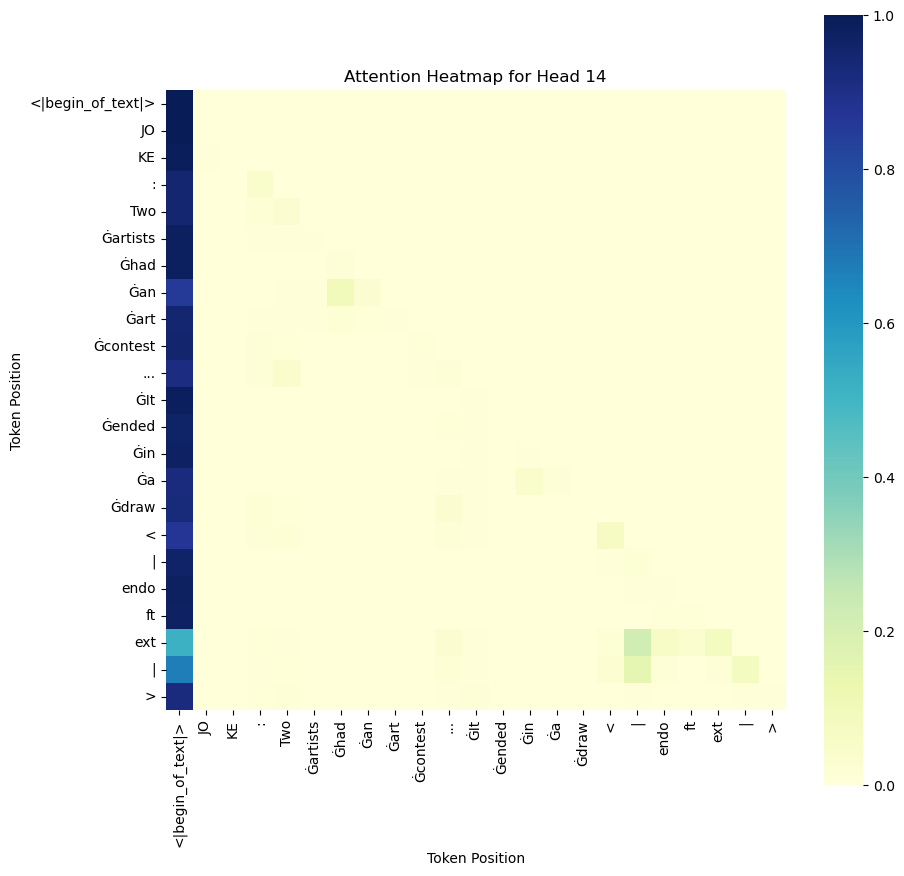

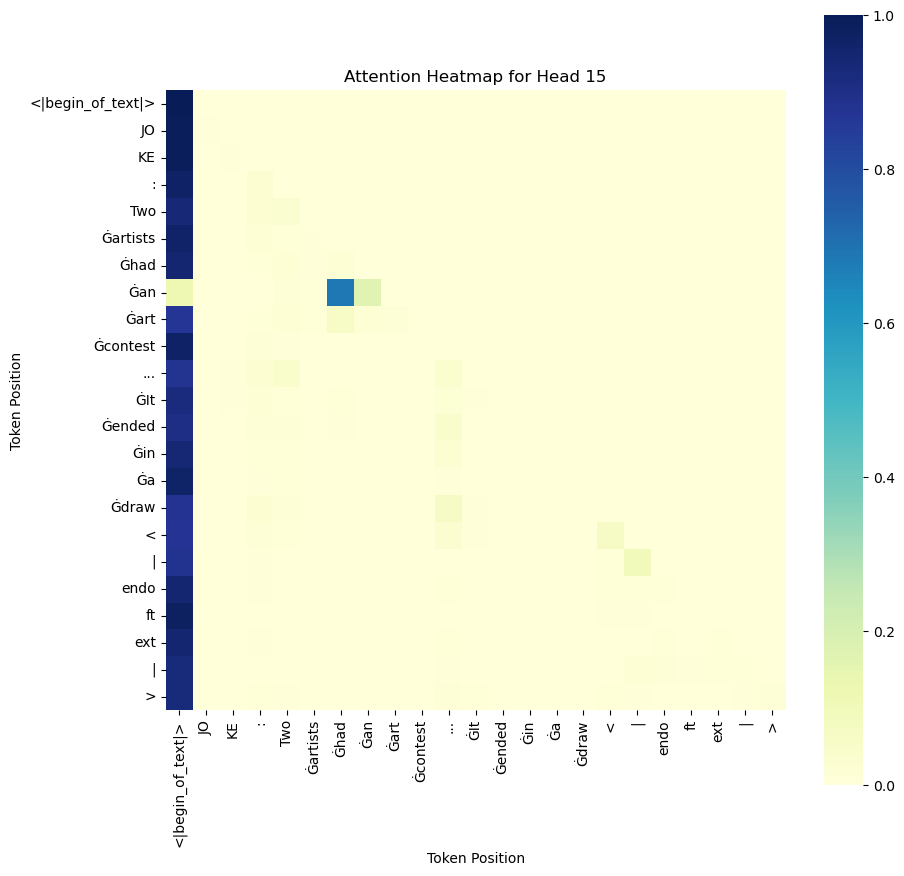

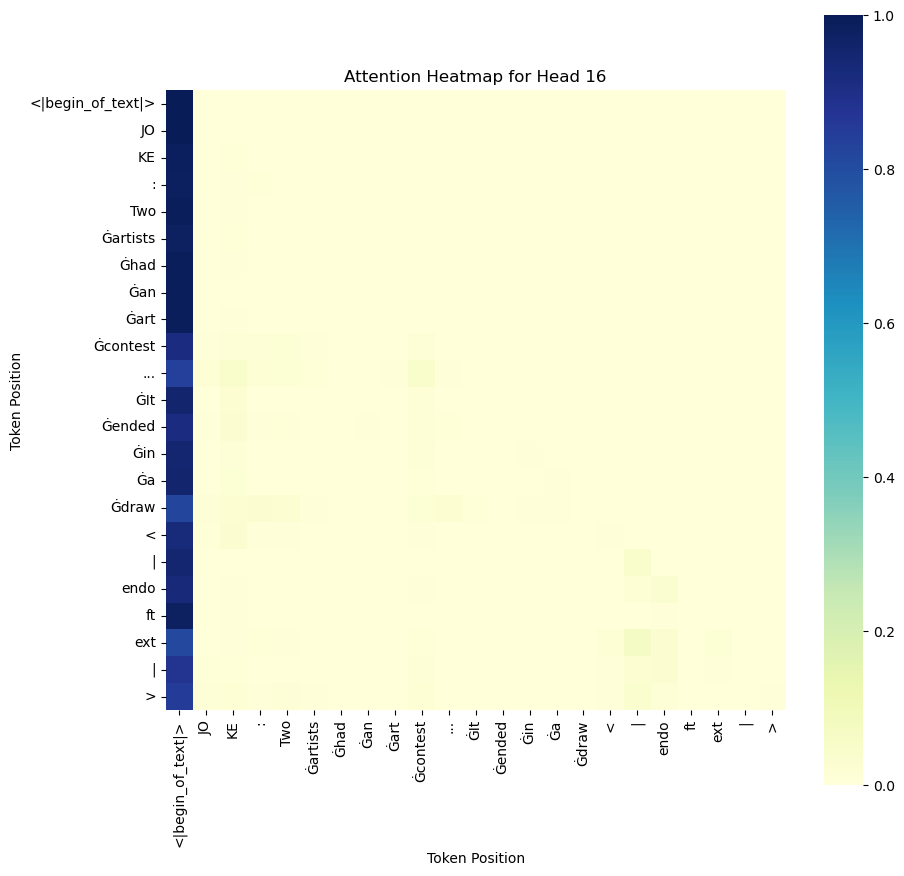

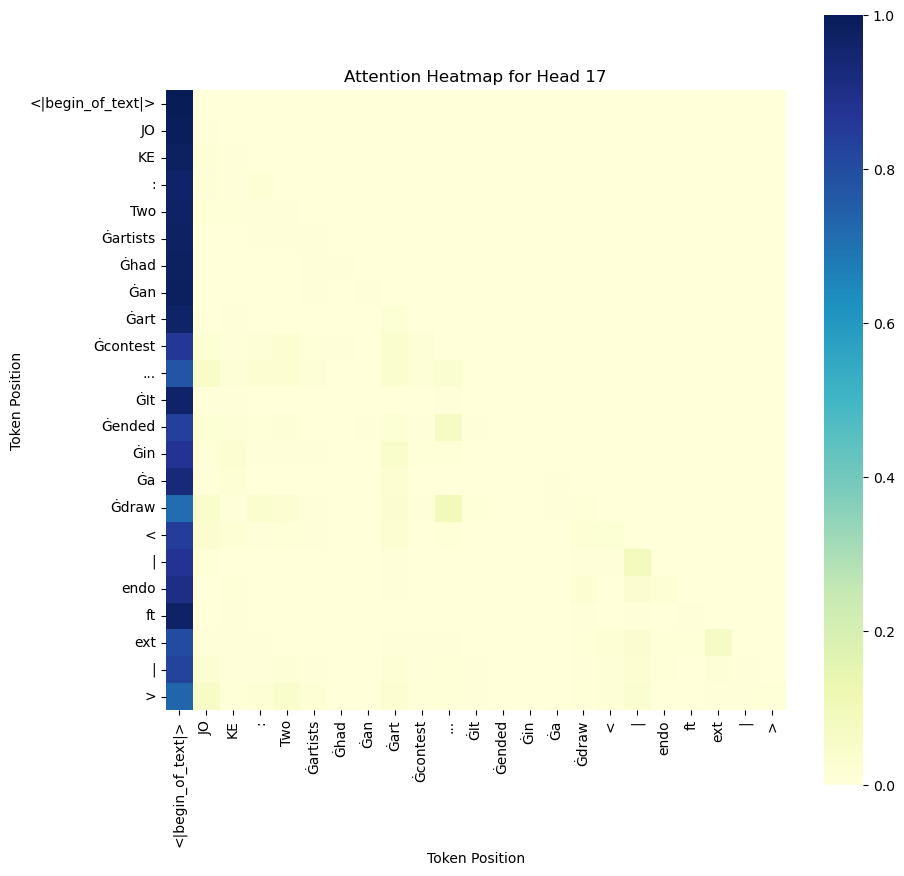

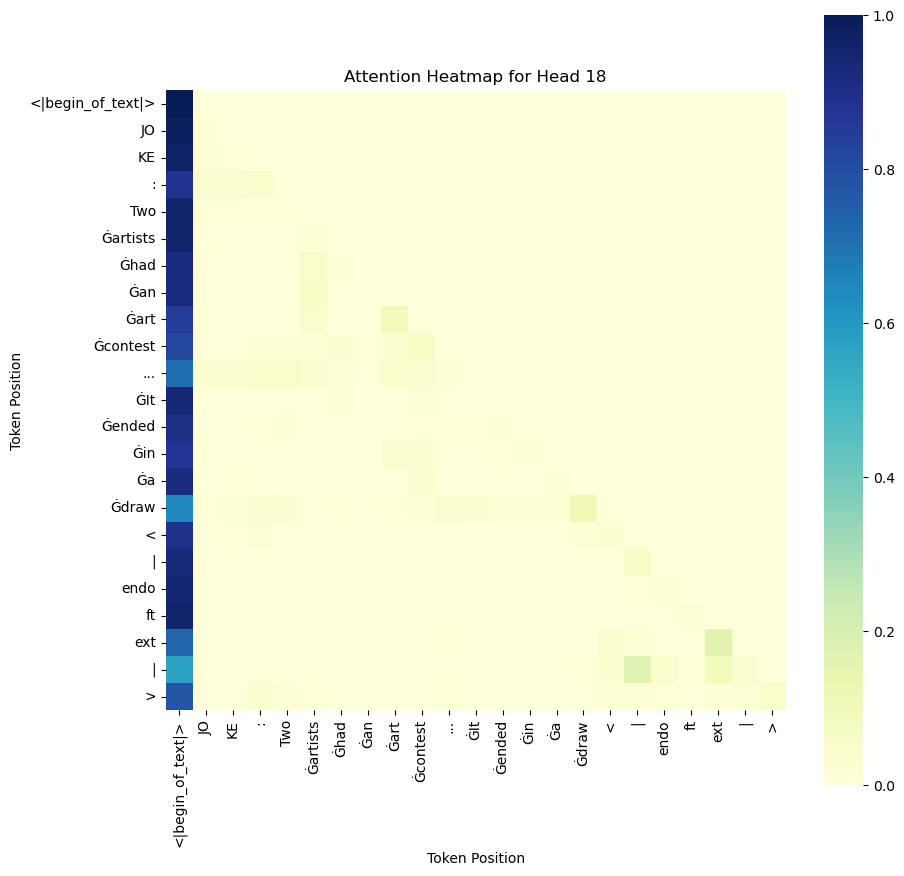

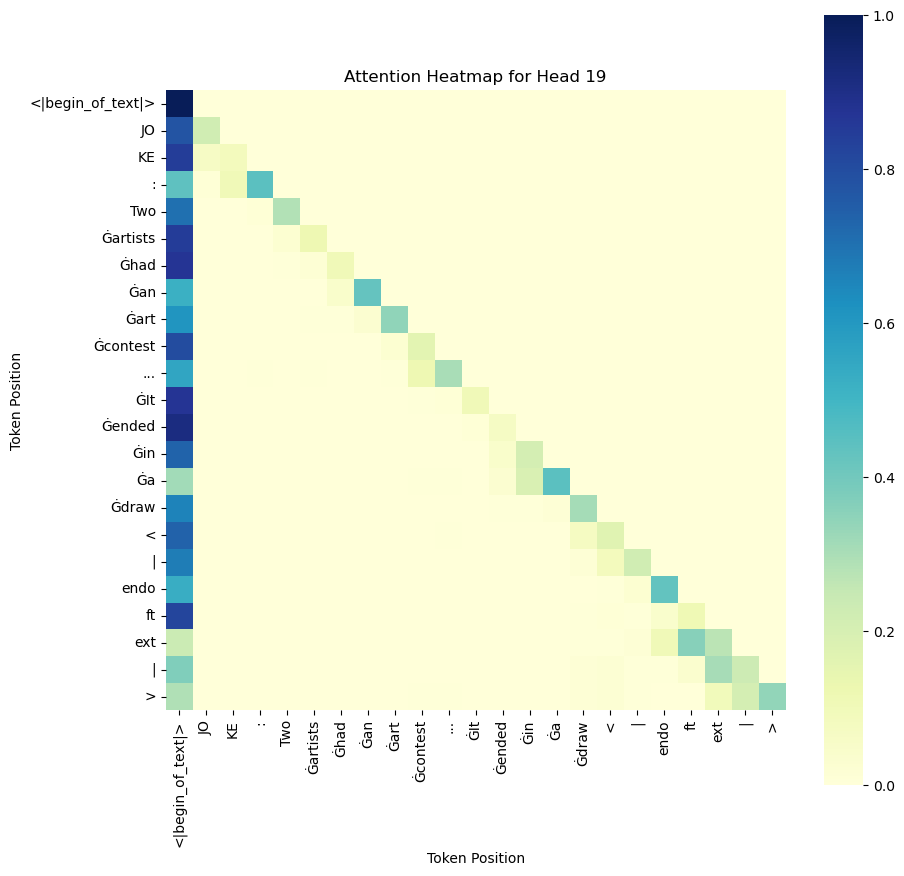

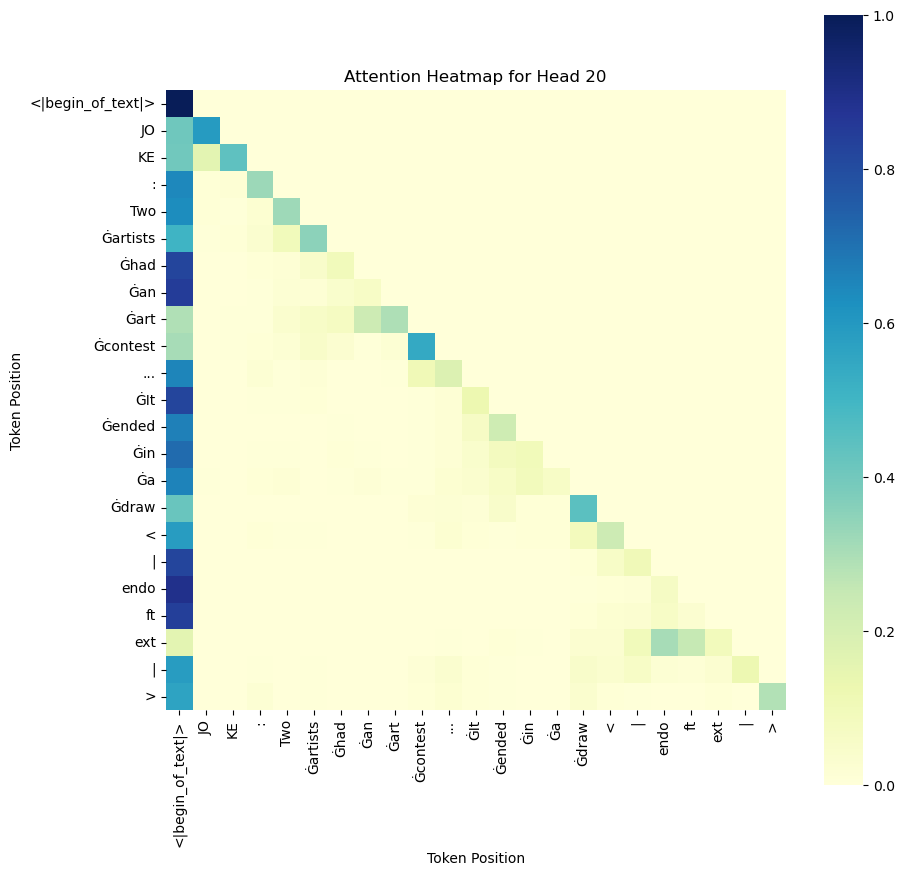

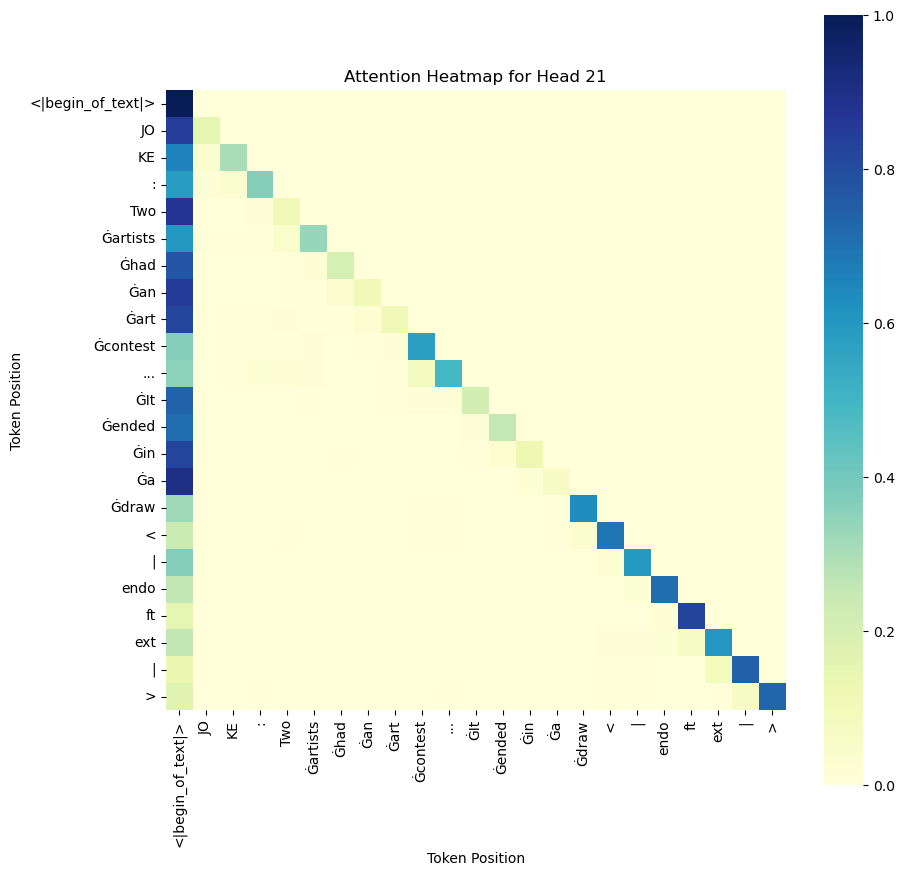

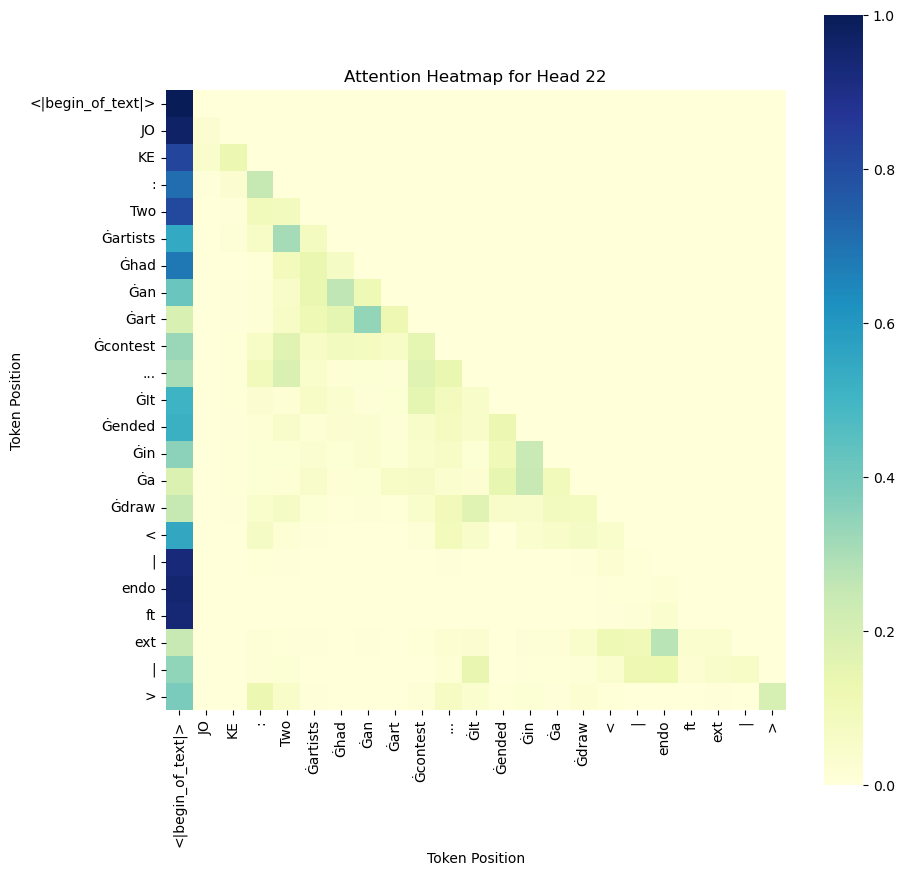

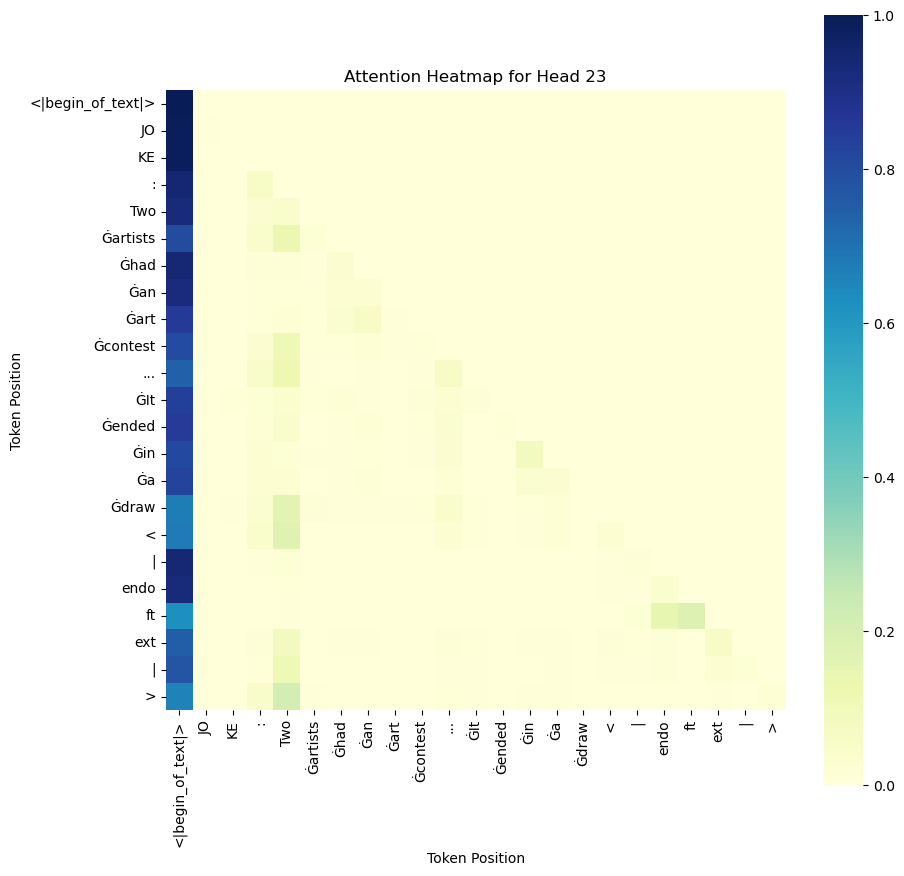

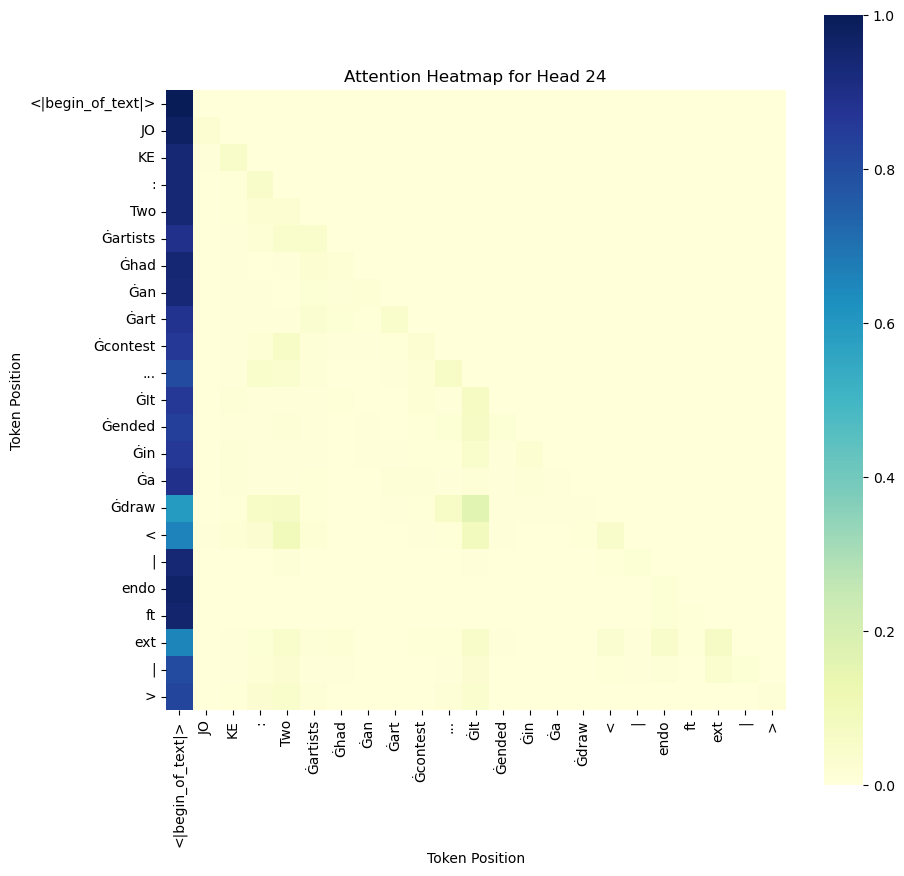

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(model, input_ids, attention_mask, tokenizer):
    input_ids = input_ids.unsqueeze(0)  # (1, seq_len)
    attention_mask = attention_mask.unsqueeze(0)
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_attentions=True
    )

    attentions = outputs.attentions 
    attention = attentions[-1]
    attention = attention.squeeze(0).detach().cpu().numpy() 

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    attention_mask = attention_mask.squeeze().tolist()

    valid_indices = [i for i, mask in enumerate(attention_mask) if mask == 1]
    filtered_tokens = [tokens[i] for i in valid_indices]
    print(filtered_tokens)
    attention = attention[:, valid_indices, :][:, :, valid_indices]

    num_heads = attention.shape[0]
    for head in range(num_heads):
        plt.figure(figsize=(10, 10))
        sns.heatmap(
            attention[head],
            cmap="YlGnBu",
            xticklabels=filtered_tokens,
            yticklabels=filtered_tokens,
            square=True
        )
        plt.title(f"Attention Heatmap for Head {head + 1}")
        plt.xlabel("Token Position")
        plt.ylabel("Token Position")
        plt.xticks(rotation=90)
        plt.show()


d = dataset.__getitem__(2)
ids = d["ids"]
mask = d["mask"]
ids = ids.to(device, dtype=torch.long)
mask = mask.to(device, dtype=torch.long)

visualize_attention(model, ids, mask, tokenizer)